In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# read in all csv's

rna_clinic = pd.read_csv('outputs/rna_clinical.csv')
maf_clinic = pd.read_csv('outputs/maf_clinical.csv')
maf_data = pd.read_csv('outputs/maf_data.csv')
rna_counts = pd.read_csv('outputs/rna_counts.csv')
rna_genes = pd.read_csv('outputs/rna_genes.csv')

# Preprocess dataframes

In [4]:
# drop duplicate patient samples in rna_clinical

rna_clinical = rna_clinic.drop_duplicates(subset=['patient'])

maf_rna_patient_mask = rna_clinical['patient'].isin(maf_clinic['Tumor_Sample_Barcode'])
masked_rna_clinic = rna_clinical[maf_rna_patient_mask]

masked_rna_clinic = masked_rna_clinic.dropna(subset=['age_at_diagnosis'])
masked_rna_clinic = masked_rna_clinic.reset_index(drop=True)

# drop columns from rna_counts if they are not contained in rna_clinic['barcode']

columns_to_drop = list(rna_counts.columns.difference(masked_rna_clinic['barcode']))
columns_to_drop.remove('Unnamed: 0')
masked_rna_counts = rna_counts.drop(columns=columns_to_drop, axis=1)

rna_counts2 = masked_rna_counts.set_index('Unnamed: 0')

# Statistics on patient clinical data

In [5]:
# create a dataframe which is a subset of relevant clinical variables

columns_from_clin = ['barcode','patient','age_at_diagnosis','race','gender']

# remove nan values
feature_df = masked_rna_clinic[columns_from_clin]

feature_df2 = feature_df.dropna(subset=['age_at_diagnosis'])
feature_df2 = feature_df2.reset_index(drop=True)

# Prepare default df

feature_df2['age_at_diagnosis'] = feature_df2['age_at_diagnosis']/365

In [6]:
# Add age_category column with 1 for Old and 0 for Young (old: >=60)

feature_df2['age_cat'] = 0
for row_i in range(feature_df2.shape[0]):
    if feature_df2.loc[row_i,'age_at_diagnosis'] > 50:
        feature_df2.loc[row_i,'age_cat'] = 1
        
print(f'Total Patients: {feature_df2.shape[0]}')
print(f"Number of old patients: {feature_df2['age_cat'].sum()}")
print(f"Number of young patients: {feature_df2.shape[0]-feature_df2['age_cat'].sum()}")

# Separate into young_df and old_df
old_mask = feature_df2['age_cat'] == 1
young_mask = feature_df2['age_cat'] == 0
old_df = feature_df2[old_mask]
young_df = feature_df2[young_mask]

Total Patients: 423
Number of old patients: 372
Number of young patients: 51


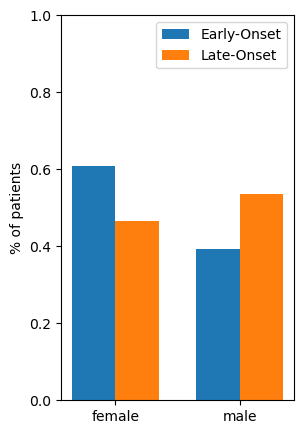

In [7]:
# Barplot to compare gender in patients

genders = list(old_df['gender'].unique())

old_gender_data = []
young_gender_data = []
for gender in genders:
    num_old = ((old_df['gender'] == gender).sum())/old_df.shape[0]
    num_young = ((young_df['gender'] == gender).sum())/young_df.shape[0]
    old_gender_data.append(num_old)
    young_gender_data.append(num_young)

bar_width = 0.35
index = np.arange(len(genders))

fig,ax = plt.subplots(figsize=(3,5))

ax.bar(index,young_gender_data,width=bar_width,label='Early-Onset')
ax.bar(index+bar_width,old_gender_data,width=bar_width,label='Late-Onset')
ax.set_xticks(index + bar_width / 2, genders)
ax.set_ylabel('% of patients')
ax.set_ylim(0,1)
ax.legend()

plt.show()

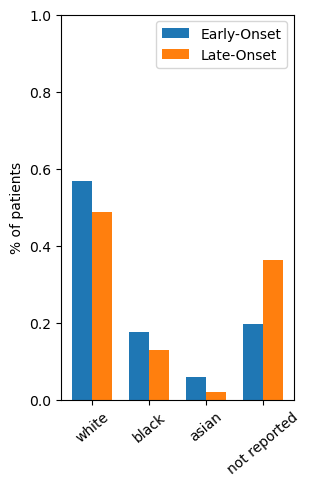

In [8]:
# Barplot to compare race in patients

races = ['white','black or african american','asian','not reported']

old_race_data = []
young_race_data = []
for race in races:
    num_old = ((old_df['race'] == race).sum())/old_df.shape[0]
    num_young = ((young_df['race'] == race).sum())/young_df.shape[0]
    old_race_data.append(num_old)
    young_race_data.append(num_young)

bar_width = 0.35
index = np.arange(len(races))

fig,ax = plt.subplots(figsize=(3,5))

races = ['white','black','asian','not reported']

ax.bar(index,young_race_data,width=bar_width,label='Early-Onset')
ax.bar(index+bar_width,old_race_data,width=bar_width,label='Late-Onset')
ax.set_xticks(index + bar_width / 2, races,rotation=40)
ax.set_ylabel('% of patients')
ax.set_ylim(0,1)
ax.legend()

plt.show()

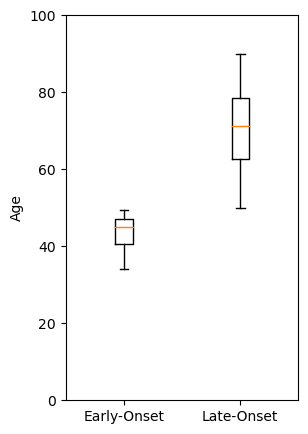

In [9]:
# Boxplot to compare race between old and young

old_ages = old_df['age_at_diagnosis'].tolist()
young_ages = young_df['age_at_diagnosis'].tolist()

bar_width = 0.35
index = np.arange(len(races))

fig,ax = plt.subplots(figsize=(3,5))

races = ['white','black','asian','not reported']

ax.boxplot([young_ages,old_ages],labels=['Early-Onset', 'Late-Onset'])
ax.set_ylabel('Age')
ax.set_ylim(0,100)

plt.show()

# Boxplots of expression

In [10]:
# create a dataframe which is a subset of relevant clinical variables

columns_from_clin = ['barcode','patient','age_at_diagnosis']

# remove nan values
feature_df2 = masked_rna_clinic.loc[:,columns_from_clin]

# Prepare default df

feature_df2['age_at_diagnosis'] = feature_df2['age_at_diagnosis']/365

In [12]:
# Add age_category column with 1 for Old and 0 for Young (old: >=60)

feature_df2['age_cat'] = 0
for row_i in range(feature_df2.shape[0]):
    if feature_df2.loc[row_i,'age_at_diagnosis'] > 50:
        feature_df2.loc[row_i,'age_cat'] = 1

In [13]:
rna_list = ['MYC','ASCL2','ALDH1A1','PEG10','NFE2L2','CLC','EIF4E','LTBP4','PLA2G12A','PPAT','ZNF574']

In [14]:
# Add rna expression for key rna's to dataframe

feature_list = rna_list

rna_dict = {}
for rna in feature_list:
    rna_index = rna_genes.loc[rna_genes['gene_name'] == rna].index
    gene_id = rna_genes.loc[rna_index,'gene_id'].values
    rna_dict[rna] = gene_id[0]

for rna in rna_dict.keys():
    
    gene_id = rna_dict[rna]
    expression_vals = []
    
    for row_i in range(feature_df2.shape[0]):
        patient_barcode = feature_df2.loc[row_i,'barcode']
        patient_expression = rna_counts2.loc[gene_id,patient_barcode]
        expression_vals.append(patient_expression)
     
    col_name = f'rna_{rna}'
    feature_df2[col_name] = expression_vals 
    
# log2 transform the rna_expression data
feature_df2.iloc[:,-len(rna_list):] = np.log2(feature_df2.iloc[:,-len(rna_list):] + 1)

In [16]:
feature_df2.head()

,barcode,patient,age_at_diagnosis,age_cat,rna_MYC,rna_ASCL2,rna_ALDH1A1,rna_PEG10,rna_NFE2L2,rna_CLC,rna_EIF4E,rna_LTBP4,rna_PLA2G12A,rna_PPAT,rna_ZNF574
0,TCGA-D5-5538-01A-01R-1653-07,TCGA-D5-5538,60.202740,1,13.247186,12.113742,9.372865,4.459432,12.130571,7.870365,11.410451,11.223398,10.249113,10.504819,10.231221
1,TCGA-AA-A02K-01A-03R-A32Y-07,TCGA-AA-A02K,50.701370,1,13.866893,12.701306,9.712527,2.807355,12.289731,1.000000,11.564626,14.103288,10.970825,10.674192,10.880349
2,TCGA-D5-6922-01A-11R-1928-07,TCGA-D5-6922,76.084932,1,14.245478,12.626394,11.569381,7.781360,12.312032,5.491853,11.106563,12.881305,11.330917,10.819381,11.197831
3,TCGA-AD-5900-01A-11R-1653-07,TCGA-AD-5900,67.879452,1,13.568906,10.303781,11.600378,5.459432,11.941414,1.584963,10.481799,11.830911,9.337622,10.466586,10.385862
4,TCGA-AA-3495-01A-01R-1410-07,TCGA-AA-3495,79.139726,1,13.187507,11.058668,9.495855,6.169925,11.163650,3.807355,9.554589,9.449149,8.974415,8.829723,8.503826


In [17]:
old_mask = feature_df2['age_cat'] == 1
young_mask = feature_df2['age_cat'] == 0
old_df = feature_df2[old_mask]
young_df = feature_df2[young_mask]

In [20]:
# Log 2 scale the DataFrames
old_df_log2 = old_df.iloc[:, 4:]
young_df_log2 = young_df.iloc[:, 4:]

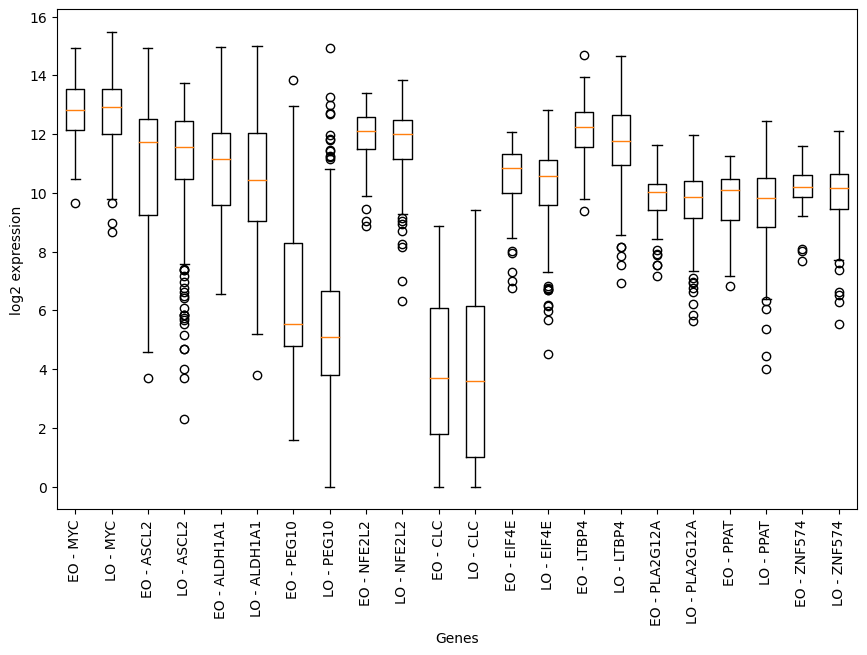

In [22]:
# Plotting differences in rna expression (with log2 transformation)

data = []

for i in range(11):
    col_data = []
    for row_i in range(young_df_log2.shape[0]):
        col_data.append(young_df_log2.iloc[row_i, i])
    data.append(col_data)
    col_data = []
    for row_i in range(old_df_log2.shape[0]):
        col_data.append(old_df_log2.iloc[row_i, i])
    data.append(col_data)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)

ax.set_xlabel('Genes')
ax.set_ylabel('log2 expression')

ax.set_xticklabels(['EO - MYC', 'LO - MYC' , 'EO - ASCL2', 'LO - ASCL2', 'EO - ALDH1A1', 'LO - ALDH1A1', 'EO - PEG10', 'LO - PEG10', 'EO - NFE2L2', 'LO - NFE2L2', 'EO - CLC', 'LO - CLC', 'EO - EIF4E', 'LO - EIF4E', 'EO - LTBP4', 'LO - LTBP4', 'EO - PLA2G12A', 'LO - PLA2G12A', 'EO - PPAT', 'LO - PPAT', 'EO - ZNF574', 'LO - ZNF574'], rotation=90)


plt.show()

# Attempting to Reproduce Findings from Literature

In [28]:
# create a dataframe which is a subset of relevant clinical variables

columns_from_clin = ['barcode','patient','age_at_diagnosis']

# remove nan values
feature_df2 = masked_rna_clinic.loc[:,columns_from_clin]

# Prepare default df

feature_df2['age_at_diagnosis'] = feature_df2['age_at_diagnosis']/365

In [29]:
# Add age_category column with 1 for Old and 0 for Young (old: >=60)

feature_df2['age_cat'] = 0
for row_i in range(feature_df2.shape[0]):
    if feature_df2.loc[row_i,'age_at_diagnosis'] > 50:
        feature_df2.loc[row_i,'age_cat'] = 1
        
print(f'Total Patients: {feature_df2.shape[0]}')
print(f"Number of old patients: {feature_df2['age_cat'].sum()}")
print(f"Number of young patients: {feature_df2.shape[0]-feature_df2['age_cat'].sum()}")

Total Patients: 423
Number of old patients: 372
Number of young patients: 51


In [30]:
# lists of mutations and DE genes from lit search

gene_list = ['CTNNB1','RNF43','BRCA2','PHLPP1','TOPORS','ATR','MYCBP2','FBXW7','POLE','NOMO1','PTEN','APC','DNMT3B','MET','KRAS']

rna_list = ['MYC','ASCL2','ALDH1A1','PEG10','NFE2L2','CLC','EIF4E','LTBP4','PLA2G12A','PPAT','ZNF574']

In [31]:
# Add rna expression for key rna's to dataframe

feature_list = rna_list + gene_list

rna_dict = {}
for rna in feature_list:
    rna_index = rna_genes.loc[rna_genes['gene_name'] == rna].index
    gene_id = rna_genes.loc[rna_index,'gene_id'].values
    rna_dict[rna] = gene_id[0]

for rna in rna_dict.keys():
    
    gene_id = rna_dict[rna]
    expression_vals = []
    
    for row_i in range(feature_df2.shape[0]):
        patient_barcode = feature_df2.loc[row_i,'barcode']
        patient_expression = rna_counts2.loc[gene_id,patient_barcode]
        expression_vals.append(patient_expression)
     
    col_name = f'rna_{rna}'
    feature_df2[col_name] = expression_vals 

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from umap import UMAP
import matplotlib.pyplot as plt

In [33]:
# drop patient id's from dataframe

patient_ids = feature_df2.loc[:,['barcode','patient']]
age = feature_df2['age_at_diagnosis']
age_cat = feature_df2['age_cat']

X_df = feature_df2.drop(columns=['barcode','patient','age_cat','age_at_diagnosis'])
X_df.head()

,rna_MYC,rna_ASCL2,rna_ALDH1A1,rna_PEG10,rna_NFE2L2,rna_CLC,rna_EIF4E,rna_LTBP4,rna_PLA2G12A,rna_PPAT,rna_ZNF574,rna_CTNNB1,rna_RNF43,rna_BRCA2,rna_PHLPP1,rna_TOPORS,rna_ATR,rna_MYCBP2,rna_FBXW7,rna_POLE,rna_NOMO1,rna_PTEN,rna_APC,rna_DNMT3B,rna_MET,rna_KRAS
0,9722,4431,662,21,4483,233,2721,2390,1216,1452,1201,31818,3521,874,628,1303,1616,2310,688,2020,2805,2985,1340,164,5664,3357
1,14939,6659,838,6,5006,1,3028,17599,2006,1633,1884,14289,6256,1980,962,1251,2473,1429,581,6132,2635,2906,1813,453,11517,2841
2,19422,6322,3038,219,5084,44,2204,7544,2575,1806,2348,37284,6631,1018,1378,1383,2507,5227,1121,5717,2956,3456,1120,858,15989,2255
3,12151,1263,3104,43,3932,2,1429,3642,646,1414,1337,20705,1892,556,1470,825,853,2476,541,3143,1554,3314,1087,254,3765,2005
4,9328,2132,721,71,2293,13,751,698,502,454,362,12580,1916,199,261,361,702,693,221,867,703,1252,383,194,3193,759


In [34]:
# normalize RNA expression values

scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_df)

/Users/abwilk/anaconda3/envs/qbio_490_andrew_wilk/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/2946193061.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
/Users/abwilk/anaconda3/envs/qbio_490_andrew_wilk/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10

Text(0, 0.5, 'UMAP_2')

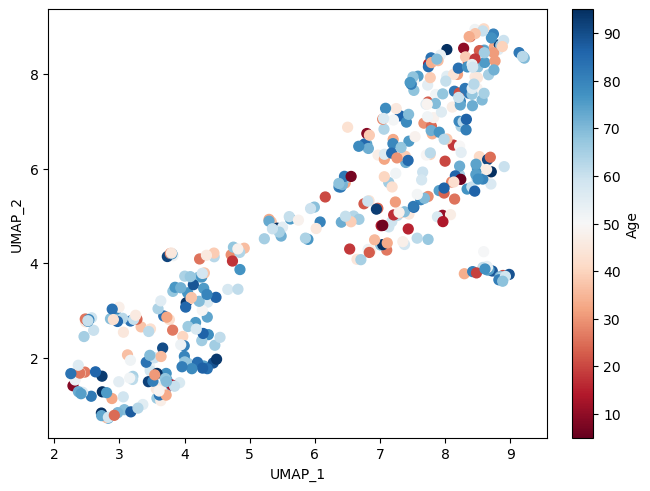

In [35]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.cluster import KMeans

# clustering with color gradient

reducer = UMAP(min_dist=0.001,random_state=42)
embedding = reducer.fit_transform(scaled_X)
x_vals = embedding[:, 0]
y_vals = embedding[:, 1]

fig, axs = plt.subplots(constrained_layout=True)

norm_age = Normalize(vmin=5, vmax=95)
# norm_age = Normalize(vmin=age.min(), vmax=age.max())
colormap = plt.cm.RdBu

sm = ScalarMappable(cmap=colormap, norm=norm_age)
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Age')

model = KMeans(n_clusters=2)

labels = model.fit_predict(embedding)


scatter = plt.scatter(x_vals, y_vals, c=age, cmap=colormap,s=50, linewidth=1, alpha=1)

axs.set_xlabel('UMAP_1')
axs.set_ylabel('UMAP_2')

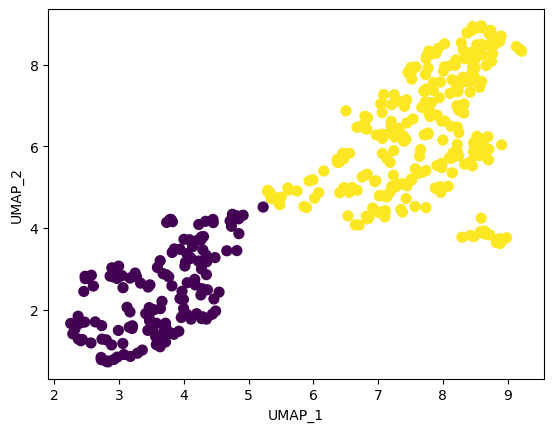

In [40]:
plt.scatter(x_vals, y_vals, c=labels, cmap='viridis',s=50, linewidth=1, alpha=1)
plt.xlabel('UMAP_1')
plt.ylabel('UMAP_2')
plt.show()

In [41]:
cluster1mask = (labels == 1)
cluster1 = x_vals[cluster1mask]
print(cluster1.mean())

cluster0mask = (labels == 0)
cluster0 = x_vals[cluster0mask]
print(cluster0.mean())


7.7192464
3.5880654


/Users/abwilk/anaconda3/envs/qbio_490_andrew_wilk/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1: 3.5880653858184814
0: 7.7192463874816895
Number of patients in class 0: 264
Number of patients in class 1: 159


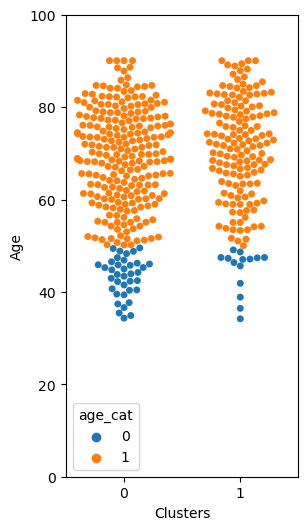

In [43]:
import seaborn as sns

model = KMeans(n_clusters=2)

labels = model.fit_predict(embedding)

cluster1mask = (labels == 1)
cluster1 = x_vals[cluster1mask]
print(f'1: {cluster1.mean()}')

cluster0mask = (labels == 0)
cluster0 = x_vals[cluster0mask]
print(f'0: {cluster0.mean()}')

from sklearn.cluster import KMeans

# Comparing the clusters

feature_df3 = feature_df2.copy(deep=True)
feature_df3['Class'] = labels
one_mask = feature_df3['Class'] == 1
one_df = feature_df3[one_mask]
zero_mask = feature_df3['Class'] == 0
zero_df = feature_df3[zero_mask]

swarm_df = feature_df3.loc[:,['Class','age_at_diagnosis','age_cat']]

print(f'Number of patients in class 0: {zero_df.shape[0]}')
print(f'Number of patients in class 1: {one_df.shape[0]}')

zero_ages = zero_df['age_at_diagnosis'].tolist()
one_ages = one_df['age_at_diagnosis'].tolist()

fig,ax = plt.subplots(figsize=(3,6))


sns.swarmplot(x='Class', y='age_at_diagnosis', hue='age_cat',data=swarm_df)

ax.set_ylabel('Age')
ax.set_ylim(0,100)
ax.set_xlabel('Clusters')

plt.show()


# Finding our own DE genes and mutations

In [54]:
# save rna_counts and rna_clinical to pandas df.

rna_counts_path = '/Users/abwilk/Documents/Fall 2023/QBIO 490/qbio490_fa23_final_CRC/outputs/rna_counts2.csv'
rna_clinic_path = '/Users/abwilk/Documents/Fall 2023/QBIO 490/qbio490_fa23_final_CRC/outputs/rna_clinic2.csv'

rna_counts2.to_csv(rna_counts_path, index=True)
masked_rna_clinic.to_csv(rna_clinic_path, index=True)


KeyboardInterrupt



In [55]:
#### Run Part 2 of R Script, then load the following csv file ####


path = '/Users/abwilk/Documents/Fall 2023/QBIO 490/qbio490_fa23_final_CRC/outputs/DE_genes.csv'
DE_genes = pd.read_csv(path)

DE_genes_list = DE_genes['x'].tolist()

In [56]:
# create a dataframe which is a subset of relevant clinical variables

columns_from_clin = ['barcode','patient','age_at_diagnosis']

# remove nan values
feature_df2 = masked_rna_clinic.loc[:,columns_from_clin]

# Prepare default df

feature_df2['age_at_diagnosis'] = feature_df2['age_at_diagnosis']/365

In [57]:
# Add age_category column with 1 for Old and 0 for Young (old: >=60)

feature_df2['age_cat'] = 0
for row_i in range(feature_df2.shape[0]):
    if feature_df2.loc[row_i,'age_at_diagnosis'] > 50:
        feature_df2.loc[row_i,'age_cat'] = 1
        
print(f'Total Patients: {feature_df2.shape[0]}')
print(f"Number of old patients: {feature_df2['age_cat'].sum()}")
print(f"Number of young patients: {feature_df2.shape[0]-feature_df2['age_cat'].sum()}")

# Separate into young_df and old_df

old_mask = feature_df2['age_cat'] == 1
young_mask = feature_df2['age_cat'] == 0
old_df = feature_df2[old_mask]
young_df = feature_df2[young_mask]

Total Patients: 423
Number of old patients: 372
Number of young patients: 51


In [58]:
# Removes duplicate mutations from maf_data

maf_simple_data = maf_data[['Hugo_Symbol','Tumor_Sample_Barcode']]
maf_simple_no_dups = maf_simple_data.drop_duplicates()

# Subdivide maf_data into old and young subsets

maf_gene_list = maf_simple_no_dups['Hugo_Symbol'].unique()

young_barcodes = list(young_df['patient'])
young_mask = np.isin(maf_simple_no_dups['Tumor_Sample_Barcode'],young_barcodes)
young_maf = maf_simple_no_dups[young_mask]

old_barcodes = list(old_df['patient'])
old_mask = np.isin(maf_simple_no_dups['Tumor_Sample_Barcode'],old_barcodes)
old_maf = maf_simple_no_dups[old_mask]

# Identify top 50 differentially mutated genes

num_young = len(young_barcodes)
young_mut_freq = []
young_mut_counts = young_maf['Hugo_Symbol'].value_counts()
for gene in maf_gene_list:
    occurences = young_mut_counts.get(gene,0)
    freq = occurences/num_young
    young_mut_freq.append(freq)
young_mut_freq_series = pd.Series(young_mut_freq,index=maf_gene_list)

num_old = len(old_barcodes)
old_mut_freq = []
old_mut_counts = old_maf['Hugo_Symbol'].value_counts()
for gene in maf_gene_list:
    occurences = old_mut_counts.get(gene,0)
    freq = occurences/num_old
    old_mut_freq.append(freq)
old_mut_freq_series = pd.Series(old_mut_freq,index=maf_gene_list)
    
diff_arr = np.absolute(young_mut_freq_series - old_mut_freq_series)

top_mutations = diff_arr.nlargest(50).index
top_mutations

Index(['MCHR2', 'PTEN', 'APC', 'RGS12', 'MAP1A', 'LCT', 'PLCE1', 'SULF1',
       'ASXL1', 'KANSL1', 'CTCF', 'SIN3A', 'PLXNA1', 'POLQ', 'CSMD3', 'ABCC12',
       'DPP10', 'MUC16', 'ABCB8', 'UNC5B', 'COL3A1', 'WNK2', 'LTBP4', 'PRPF4B',
       'SPPL2B', 'ZNF536', 'REXO1', 'MYH14', 'NLRC5', 'MAP2K7', 'ERBB4',
       'FAT4', 'FNDC1', 'SPAG17', 'UBR5', 'PIK3C2G', 'VPS13B', 'TRPS1',
       'SAFB2', 'DEPDC5', 'AC006059.2', 'BTN2A2', 'SDK2', 'PLXNB1', 'SPTA1',
       'KIF2B', 'TMPO', 'CEP85L', 'FAM214A', 'CECR2'],
      dtype='object')

In [60]:
# Add mutation info to feature_df2

for gene in top_mutations:
    gene_mask = maf_simple_no_dups['Hugo_Symbol'] == gene
    masked_maf = maf_simple_no_dups[gene_mask]
    
    has_mutation = np.isin(feature_df2['patient'], masked_maf['Tumor_Sample_Barcode'])
    
    colname = f'mut_{gene}'
    feature_df2[colname] = has_mutation
    
# Create new young_df and old_df

old_mask = feature_df2['age_cat'] == 1
young_mask = feature_df2['age_cat'] == 0
old_df = feature_df2[old_mask]
young_df = feature_df2[young_mask]

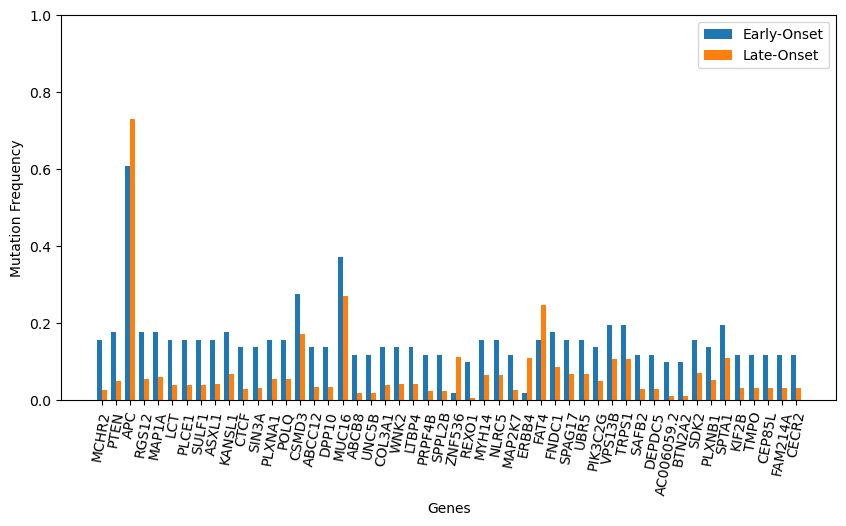

In [61]:
# Find the percent occurence of the mutations
num_mutations = len(top_mutations)
young_gene_freq = young_df.iloc[:,-num_mutations:].sum()/young_df.shape[0]
old_gene_freq = old_df.iloc[:,-num_mutations:].sum()/old_df.shape[0]

# Plotting differences in mutation frequency

bar_width = 0.35
index = np.arange(len(top_mutations))

labels = top_mutations

fig,ax = plt.subplots(figsize=(10,5))

ax.bar(index,young_gene_freq,width=bar_width,label='Early-Onset')
ax.bar(index+bar_width,old_gene_freq,width=bar_width,label='Late-Onset')
ax.set_xticks(index + bar_width / 2, labels,rotation=80)
ax.set_ylabel('Mutation Frequency')
ax.set_ylim(0,1)
ax.set_xlabel('Genes')
# ax.set_title('Comparing gene mutation frequency between old and young CRC patients')
ax.legend()

plt.show()

In [62]:
# create a dataframe which is a subset of relevant clinical variables

columns_from_clin = ['barcode','patient','age_at_diagnosis']

# remove nan values
feature_df2 = masked_rna_clinic.loc[:,columns_from_clin]

# Prepare default df

feature_df2['age_at_diagnosis'] = feature_df2['age_at_diagnosis']/365

# Add age_category column with 1 for Old and 0 for Young (old: >=60)

feature_df2['age_cat'] = 0
for row_i in range(feature_df2.shape[0]):
    if feature_df2.loc[row_i,'age_at_diagnosis'] > 50:
        feature_df2.loc[row_i,'age_cat'] = 1
        
print(f'Total Patients: {feature_df2.shape[0]}')
print(f"Number of old patients: {feature_df2['age_cat'].sum()}")
print(f"Number of young patients: {feature_df2.shape[0]-feature_df2['age_cat'].sum()}")

# Separate into young_df and old_df

old_mask = feature_df2['age_cat'] == 1
young_mask = feature_df2['age_cat'] == 0
old_df = feature_df2[old_mask]
young_df = feature_df2[young_mask]

Total Patients: 423
Number of old patients: 372
Number of young patients: 51


In [63]:
# Add rna info to feature_df2

# Want to add 166 DE Genes, 50 Mutated Genes, and Genes from literature

gene_master_list = []
gene_master_list += DE_genes_list
gene_master_list += list(top_mutations)
gene_master_list += feature_list

for gene_name in gene_master_list:
    
    if rna_genes['gene_name'].str.contains(gene_name).any():
        index = rna_genes.loc[rna_genes['gene_name'] == gene_name].index    
    else:
        pass
    
    gene_id = rna_genes.loc[index, 'gene_id'].values[0]
    expression_vals = []

    for row_i in range(feature_df2.shape[0]):
        patient_barcode = feature_df2.loc[row_i,'barcode']
        patient_expression = rna_counts2.loc[gene_id,patient_barcode]
        expression_vals.append(patient_expression)
     
    col_name = f'rna_{gene_name}'
    feature_df2[col_name] = expression_vals
    
# Separate into young_df and old_df

old_mask = feature_df2['age_cat'] == 1
young_mask = feature_df2['age_cat'] == 0
old_df = feature_df2[old_mask]
young_df = feature_df2[young_mask]

/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feature_df2[col_name] = expression_vals
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/3125379953.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

# Clustering with our own genes

In [64]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from umap import UMAP

In [66]:
# drop patient id's from dataframe

patient_ids = feature_df2.loc[:,['barcode','patient']]
age = feature_df2['age_at_diagnosis']
age_cat = feature_df2['age_cat']

X_df = feature_df2.drop(columns=['barcode','patient','age_cat','age_at_diagnosis'])
X_df.head()

# normalize RNA expression values

scaler = StandardScaler()

scaled_X = scaler.fit_transform(X_df)

/Users/abwilk/anaconda3/envs/qbio_490_andrew_wilk/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/yw/67xvydx5669f_gz02ss9kl8c0000gn/T/ipykernel_91941/908895401.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
/Users/abwilk/anaconda3/envs/qbio_490_andrew_wilk/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

Text(0, 0.5, 'UMAP_2')

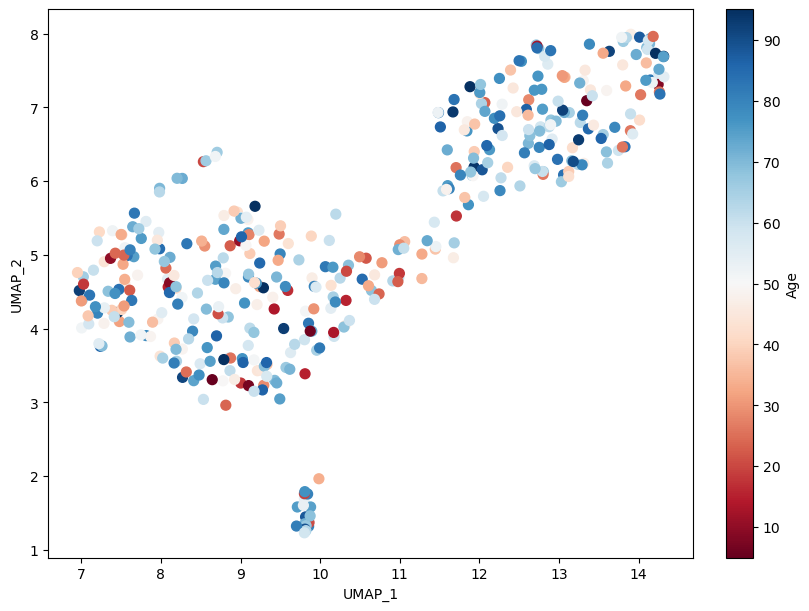

In [67]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# clustering with color gradient

reducer = UMAP(min_dist=0.01,random_state=32)
embedding = reducer.fit_transform(scaled_X)
x_vals = embedding[:, 0]
y_vals = embedding[:, 1]

fig, axs = plt.subplots(constrained_layout=True,figsize=(8,6))

norm_age = Normalize(vmin=5, vmax=95)
# norm_age = Normalize(vmin=age.min(), vmax=age.max())
colormap = plt.cm.RdBu

sm = ScalarMappable(cmap=colormap, norm=norm_age)
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Age')

model = KMeans(n_clusters=2)

labels = model.fit_predict(embedding)

scatter = plt.scatter(x_vals, y_vals, c=age, cmap=colormap, s=50, linewidth=1, alpha=1)

axs.set_xlabel('UMAP_1')
axs.set_ylabel('UMAP_2')

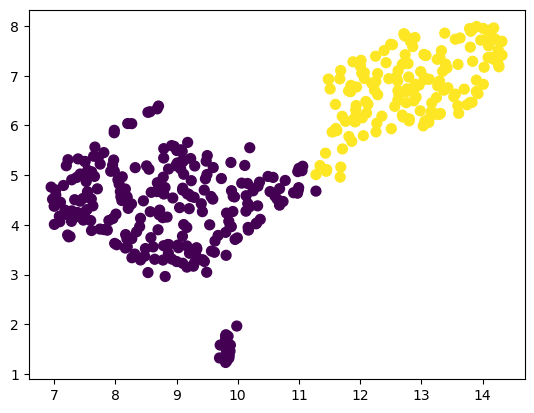

In [68]:
plt.scatter(x_vals, y_vals, c=labels, cmap='viridis', s=50, linewidth=1, alpha=1)

1: 12.86178970336914
0: 8.864273071289062
Number of patients in class 0: 257
Number of patients in class 1: 166


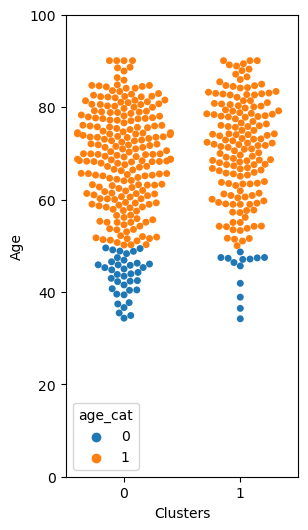

In [69]:
cluster1mask = (labels == 1)
cluster1 = x_vals[cluster1mask]
print(f'1: {cluster1.mean()}')

cluster0mask = (labels == 0)
cluster0 = x_vals[cluster0mask]
print(f'0: {cluster0.mean()}')


from sklearn.cluster import KMeans

# Comparing the clusters

feature_df3 = feature_df2.copy(deep=True)
feature_df3['Class'] = labels

one_mask = feature_df3['Class'] == 1
one_df = feature_df3[one_mask]
zero_mask = feature_df3['Class'] == 0
zero_df = feature_df3[zero_mask]

print(f'Number of patients in class 0: {zero_df.shape[0]}')
print(f'Number of patients in class 1: {one_df.shape[0]}')

zero_ages = zero_df['age_at_diagnosis'].tolist()
one_ages = one_df['age_at_diagnosis'].tolist()

fig,ax = plt.subplots(figsize=(3,6))


swarm_df = feature_df3.loc[:,['Class','age_at_diagnosis','age_cat']]
sns.swarmplot(x='Class', y='age_at_diagnosis', hue='age_cat',data=swarm_df)


ax.set_ylabel('Age')
ax.set_ylim(0,100)
ax.set_xlabel('Clusters')

plt.show()